In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import meteva.base as meb
import meteva.method as mem
import meteva.product as mpd
import numpy as np
import datetime
import copy
import matplotlib.pyplot as plt
import pandas as pd

本模块的函数族旨在提供各类数值型检验指标的分组统计方法。在浏览本模块函数说明之前可先参阅函数设计的[关键技术思想](https://www.showdoc.cc/meteva?page_id=4072178802924517)。本模块包含数值型检验指标的计算方法，为对其进行介绍，以下先对测试数据进行一个简单的介绍。

### 测试数据集：  
 **观测数据** ： 2019年全年2m温度观测数据，时间间隔3小时（1月1日02时），每个时刻包含6个站点（54398，54410，54416，54419，54499，54412）  
   
 **预报数据** ：  
    **ECMWF：** 2019年全年2m温度温度预报数据（少部分缺失），起报时刻北京时间08和20时，预报时效0-72小时内逐3小时间隔，网格范围115 - 118° E，39 - 42°N，格距 0.5°  
   
    **GRAPES_GFS：** 2019年全年2m温度温度预报数据（少部分缺失），起报时刻北京时间08和20时，预报时效0-72小时内逐3小时间隔，网格范围115 - 118° E，39 - 42°N，格距 0.5°  


########################################################
#以下先通过打印和图片的方式简单预览一下部分数据内容

In [2]:
#设置数据路径的通配格式
dir_ob = r"H:\test_data\input\mpd\ob\temp_2m\BTYYMMDDHH.000"
dir_ec = r"H:\test_data\input\mpd\ec\temp_2m\YYMMDD\BTYYMMDDHH.TTT"
dir_grapes = r"H:\test_data\input\mpd\grapes\temp_2m\YYMMDD\BTYYMMDDHH.TTT"

In [3]:
time0 = datetime.datetime(2019,7,1,20,0)   
dh = 12
path = meb.get_path(dir_ob,time0)
sta_ob= meb.read_stadata_from_micaps3(path)   #读取一个时刻的观测数据示例，并打印显示
print(sta_ob)

   level                time  dtime     id    lon   lat      data0
0      0 2019-07-01 20:00:00      0  54398  116.6  40.1  31.400000
1      0 2019-07-01 20:00:00      0  54410  116.1  40.6  20.400000
2      0 2019-07-01 20:00:00      0  54416  116.9  40.4  29.500000
3      0 2019-07-01 20:00:00      0  54419  116.6  40.4  28.500000
4      0 2019-07-01 20:00:00      0  54499  116.2  40.2  31.200001
5      0 2019-07-01 20:00:00      0  54412  116.6  40.7  27.900000


In [4]:
path = meb.get_path(dir_ec,time0,dh)
grd_ec = meb.read_griddata_from_micaps4(path)  #读取一个ec预报数据场示例
meb.set_griddata_coords(grd_ec,name = "t2m",gtime = [time0],dtime_list = [dh],member_list = ["ecmwf"])
print(grd_ec)                                  #打印显示

<xarray.DataArray 't2m' (member: 1, level: 1, time: 1, dtime: 1, lat: 7, lon: 7)>
array([[[[[[25.2, 26.9, 26.2, 27. , 26.3, 26.2, 25.3],
           [21.1, 23.9, 26.4, 25.9, 25.8, 25. , 25.5],
           [19.7, 19.7, 21.6, 25.6, 25.7, 24.6, 24.5],
           [20.1, 20.7, 20.9, 19.1, 22.4, 19.1, 19.7],
           [18.8, 15.4, 17.6, 16.6, 19.4, 18.7, 19.1],
           [16.4, 16.3, 15.1, 15.8, 16.1, 17. , 16.4],
           [16.1, 15.7, 15.7, 16.2, 14.9, 16.2, 16.1]]]]]])
Coordinates:
  * member   (member) <U5 'ecmwf'
  * level    (level) float64 -2.147e+09
  * time     (time) datetime64[ns] 2019-07-01T20:00:00
  * dtime    (dtime) int32 12
  * lat      (lat) float64 39.0 39.5 40.0 40.5 41.0 41.5 42.0
  * lon      (lon) float64 115.0 115.5 116.0 116.5 117.0 117.5 118.0
Attributes:
    dtime_type:  hour


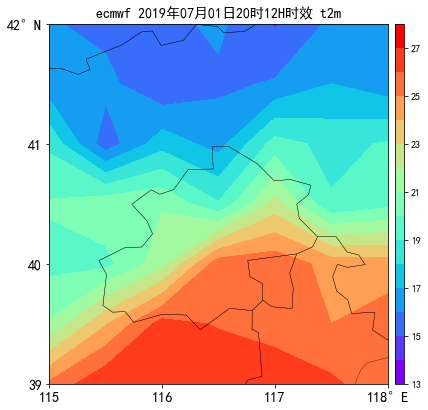

In [5]:
meb.plot_tools.contourf_2d_grid(grd_ec)   #以图片形式显示

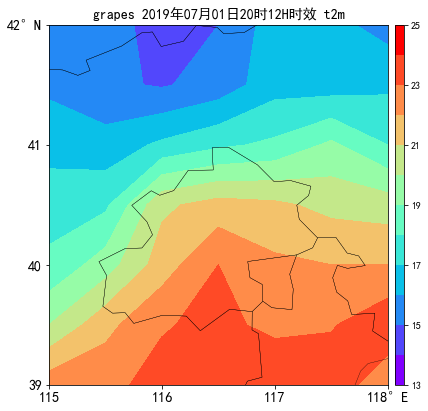

In [6]:
path = meb.get_path(dir_grapes,time0,dh)
grd_grapes = meb.read_griddata_from_micaps4(path)
meb.set_griddata_coords(grd_grapes,name = "t2m",gtime = [time0],dtime_list = [dh],member_list = ["grapes"])
meb.plot_tools.contourf_2d_grid(grd_grapes)     #以图片形式显示一个grapes预报场

#以上先通过打印和图片的方式简单预览了部分数据内容
########################################################

In [7]:
###################以下开始为数据收集部分的程序

#设置关注的起始时段
time_start = datetime.datetime(2019,1,1,8,0)   
time_end = datetime.datetime(2020,1,1,8,0)
#读取站点列表，并将站点内容为缺省值，当其作为读取站点数据的参数时，如果站点文件中某个站号不存在时,返回结果中该站点保持为缺省值
station = meb.read_stadata_from_micaps3(r"H:\test_data\input\mpd\ob\temp_2m\BT19010102.000")
station.iloc[:,-1] = meb.IV 


##读取收集观测数据
dir_ob = r"H:\test_data\input\mpd\ob\temp_2m\BTYYMMDDHH.000"
sta_list = []
time0 = time_start
while time0 < time_end:
    path = meb.get_path(dir_ob,time0)
    sta = meb.read_stadata_from_micaps3(path,station = station,time = time0,dtime = 0,level = 0,data_name = "ob",show = True)
    sta_list.append(sta)
    time0 += datetime.timedelta(hours = 3)
ob_sta_all = pd.concat(sta_list,axis = 0)  #数据拼接
    

#读取收集ec预报数据
dir_ec = r"H:\test_data\input\mpd\ec\temp_2m\YYMMDD\BTYYMMDDHH.TTT"
sta_list =[]
time0 = time_start
while time0 <= time_end:
    for dh in range(0,73,3):
        path = meb.get_path(dir_ec,time0,dh)
        grd = meb.read_griddata_from_micaps4(path,show = True)
        if grd is not None:
            sta = meb.interp_gs_linear(grd,station)
            meb.set_stadata_coords(sta,time = time0,dtime = dh,level = 0)
            meb.set_stadata_names(sta,["ecmwf"])
            sta_list.append(sta)
    time0 += datetime.timedelta(hours = 132)  #此处跳着读是为了减少测试用时
ec_sta_all = pd.concat(sta_list,axis = 0)  #数据拼接
            
#读取收集grapes预报数据
dir_grapes = r"H:\test_data\input\mpd\grapes\temp_2m\YYMMDD\BTYYMMDDHH.TTT"
sta_list =[]
time0 = time_start
while time0 <= time_end:
    for dh in range(0,73,3):
        path = meb.get_path(dir_grapes,time0,dh)
        grd = meb.read_griddata_from_micaps4(path,show = True)
        if grd is not None:
            sta = meb.interp_gs_linear(grd,station)
            meb.set_stadata_coords(sta,time = time0,dtime = dh,level = 0)
            meb.set_stadata_names(sta,["grapes"])
            sta_list.append(sta)  
    time0 += datetime.timedelta(hours = 132)
grapes_sta_all = pd.concat(sta_list,axis = 0)  #数据拼接
    
#数据匹配合并
sta_all = meb.combine_on_obTime_id(ob_sta_all,[ec_sta_all,grapes_sta_all])
sta_all = meb.sele_by_para(sta_all,drop_IV = True)  #删除包含缺省值的样本

###################以上为数据收集部分的程序

success read from H:\test_data\input\mpd\ob\temp_2m\BT19010108.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010111.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010114.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010117.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010120.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010123.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010202.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010205.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010208.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010211.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010214.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010217.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010220.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010223.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010302

success read from H:\test_data\input\mpd\ob\temp_2m\BT19011711.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011714.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011717.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011720.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011723.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011802.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011805.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011808.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011811.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011814.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011817.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011820.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011823.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011902.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011905

success read from H:\test_data\input\mpd\ob\temp_2m\BT19020205.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020208.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020211.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020214.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020217.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020220.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020223.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020302.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020305.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020308.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020311.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020314.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020317.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020320.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020323

success read from H:\test_data\input\mpd\ob\temp_2m\BT19021720.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021723.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021802.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021805.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021808.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021811.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021814.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021817.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021820.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021823.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021902.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021905.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021908.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021911.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021914

success read from H:\test_data\input\mpd\ob\temp_2m\BT19030511.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030514.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030517.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030520.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030523.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030602.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030605.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030608.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030611.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030614.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030617.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030620.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030623.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030702.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030705

success read from H:\test_data\input\mpd\ob\temp_2m\BT19032114.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032117.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032120.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032123.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032202.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032205.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032208.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032211.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032214.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032217.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032220.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032223.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032302.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032305.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032308

success read from H:\test_data\input\mpd\ob\temp_2m\BT19040602.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040605.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040608.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040611.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040614.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040617.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040620.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040623.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040702.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040705.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040708.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040711.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040714.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040717.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040720

success read from H:\test_data\input\mpd\ob\temp_2m\BT19042123.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042202.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042205.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042208.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042211.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042214.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042217.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042220.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042223.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042302.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042305.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042308.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042311.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042314.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042317

success read from H:\test_data\input\mpd\ob\temp_2m\BT19050723.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19050802.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19050808.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19050811.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19050814.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19050817.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19050820.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19050823.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19050902.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19050905.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19050908.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19050914.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19050917.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19050920.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19050923

success read from H:\test_data\input\mpd\ob\temp_2m\BT19052317.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052320.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052323.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052402.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052405.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052408.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052411.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052414.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052417.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052420.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052423.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052502.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052505.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052508.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052511

success read from H:\test_data\input\mpd\ob\temp_2m\BT19060817.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19060820.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19060823.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19060902.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19060905.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19060908.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19060911.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19060914.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19060917.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19060920.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19060923.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19061002.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19061005.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19061008.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19061011

success read from H:\test_data\input\mpd\ob\temp_2m\BT19062417.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062420.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062423.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062502.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062505.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062508.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062511.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062514.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062517.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062520.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062523.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062602.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062605.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062608.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062611

success read from H:\test_data\input\mpd\ob\temp_2m\BT19071011.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071014.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071017.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071020.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071023.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071102.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071105.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071108.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071117.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071120.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071123.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071202.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071205.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071208.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071211

success read from H:\test_data\input\mpd\ob\temp_2m\BT19081011.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081014.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081017.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081020.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081023.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081102.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081105.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081108.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081111.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081114.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081117.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081120.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081123.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081202.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081205

success read from H:\test_data\input\mpd\ob\temp_2m\BT19082605.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19082608.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19082611.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19082614.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19082617.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19082620.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19082623.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19082702.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19082705.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19082708.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19082711.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19082714.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19082717.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19082720.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19082723

success read from H:\test_data\input\mpd\ob\temp_2m\BT19091108.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091111.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091114.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091117.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091120.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091123.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091202.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091205.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091208.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091211.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091214.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091217.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091220.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091223.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091302

success read from H:\test_data\input\mpd\ob\temp_2m\BT19092711.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19092714.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19092717.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19092720.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19092723.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19092802.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19092805.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19092808.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19092811.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19092814.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19092817.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19092820.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19092823.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19092902.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19092905

success read from H:\test_data\input\mpd\ob\temp_2m\BT19101305.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19101308.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19101311.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19101314.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19101317.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19101320.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19101323.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19101402.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19101405.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19101408.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19101411.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19101414.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19101417.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19101420.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19101423

success read from H:\test_data\input\mpd\ob\temp_2m\BT19102905.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102908.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102911.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102914.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102917.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102920.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102923.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19103002.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19103005.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19103008.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19103011.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19103014.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19103017.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19103020.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19103023

success read from H:\test_data\input\mpd\ob\temp_2m\BT19111320.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19111323.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19111402.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19111405.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19111408.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19111411.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19111414.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19111417.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19111420.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19111423.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19111502.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19111505.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19111508.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19111511.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19111514

success read from H:\test_data\input\mpd\ob\temp_2m\BT19112914.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19112917.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19112920.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19112923.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19113002.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19113005.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19113008.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19113011.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19113014.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19113017.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19113020.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19113023.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19120102.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19120105.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19120108

success read from H:\test_data\input\mpd\ob\temp_2m\BT19121511.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19121514.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19121517.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19121520.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19121523.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19121602.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19121605.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19121608.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19121611.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19121614.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19121617.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19121620.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19121623.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19121702.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19121705

success read from H:\test_data\input\mpd\ob\temp_2m\BT19123114.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19123117.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19123120.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19123123.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT20010102.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT20010105.000
H:\test_data\input\mpd\ec\temp_2m\190101\BT19010108.000 is not exist
H:\test_data\input\mpd\ec\temp_2m\190101\BT19010108.003 is not exist
H:\test_data\input\mpd\ec\temp_2m\190101\BT19010108.006 is not exist
H:\test_data\input\mpd\ec\temp_2m\190101\BT19010108.009 is not exist
H:\test_data\input\mpd\ec\temp_2m\190101\BT19010108.012 is not exist
H:\test_data\input\mpd\ec\temp_2m\190101\BT19010108.015 is not exist
H:\test_data\input\mpd\ec\temp_2m\190101\BT19010108.018 is not exist
H:\test_data\input\mpd\ec\temp_2m\190101\BT19010108.021 is not exist
H:\test_data\input\mpd\ec\temp_2m\190101\BT190

success read from H:\test_data\input\mpd\ec\temp_2m\190123\BT19012308.030
success read from H:\test_data\input\mpd\ec\temp_2m\190123\BT19012308.033
success read from H:\test_data\input\mpd\ec\temp_2m\190123\BT19012308.036
success read from H:\test_data\input\mpd\ec\temp_2m\190123\BT19012308.039
success read from H:\test_data\input\mpd\ec\temp_2m\190123\BT19012308.042
success read from H:\test_data\input\mpd\ec\temp_2m\190123\BT19012308.045
success read from H:\test_data\input\mpd\ec\temp_2m\190123\BT19012308.048
success read from H:\test_data\input\mpd\ec\temp_2m\190123\BT19012308.051
success read from H:\test_data\input\mpd\ec\temp_2m\190123\BT19012308.054
success read from H:\test_data\input\mpd\ec\temp_2m\190123\BT19012308.057
success read from H:\test_data\input\mpd\ec\temp_2m\190123\BT19012308.060
success read from H:\test_data\input\mpd\ec\temp_2m\190123\BT19012308.063
success read from H:\test_data\input\mpd\ec\temp_2m\190123\BT19012308.066
success read from H:\test_data\input\m

success read from H:\test_data\input\mpd\ec\temp_2m\190219\BT19021920.003
success read from H:\test_data\input\mpd\ec\temp_2m\190219\BT19021920.006
success read from H:\test_data\input\mpd\ec\temp_2m\190219\BT19021920.009
success read from H:\test_data\input\mpd\ec\temp_2m\190219\BT19021920.012
success read from H:\test_data\input\mpd\ec\temp_2m\190219\BT19021920.015
success read from H:\test_data\input\mpd\ec\temp_2m\190219\BT19021920.018
success read from H:\test_data\input\mpd\ec\temp_2m\190219\BT19021920.021
success read from H:\test_data\input\mpd\ec\temp_2m\190219\BT19021920.024
success read from H:\test_data\input\mpd\ec\temp_2m\190219\BT19021920.027
success read from H:\test_data\input\mpd\ec\temp_2m\190219\BT19021920.030
success read from H:\test_data\input\mpd\ec\temp_2m\190219\BT19021920.033
success read from H:\test_data\input\mpd\ec\temp_2m\190219\BT19021920.036
success read from H:\test_data\input\mpd\ec\temp_2m\190219\BT19021920.039
success read from H:\test_data\input\m

success read from H:\test_data\input\mpd\ec\temp_2m\190313\BT19031320.042
success read from H:\test_data\input\mpd\ec\temp_2m\190313\BT19031320.045
success read from H:\test_data\input\mpd\ec\temp_2m\190313\BT19031320.048
success read from H:\test_data\input\mpd\ec\temp_2m\190313\BT19031320.051
success read from H:\test_data\input\mpd\ec\temp_2m\190313\BT19031320.054
success read from H:\test_data\input\mpd\ec\temp_2m\190313\BT19031320.057
success read from H:\test_data\input\mpd\ec\temp_2m\190313\BT19031320.060
success read from H:\test_data\input\mpd\ec\temp_2m\190313\BT19031320.063
success read from H:\test_data\input\mpd\ec\temp_2m\190313\BT19031320.066
success read from H:\test_data\input\mpd\ec\temp_2m\190313\BT19031320.069
success read from H:\test_data\input\mpd\ec\temp_2m\190313\BT19031320.072
success read from H:\test_data\input\mpd\ec\temp_2m\190319\BT19031908.000
success read from H:\test_data\input\mpd\ec\temp_2m\190319\BT19031908.003
success read from H:\test_data\input\m

success read from H:\test_data\input\mpd\ec\temp_2m\190410\BT19041008.009
success read from H:\test_data\input\mpd\ec\temp_2m\190410\BT19041008.012
success read from H:\test_data\input\mpd\ec\temp_2m\190410\BT19041008.015
success read from H:\test_data\input\mpd\ec\temp_2m\190410\BT19041008.018
success read from H:\test_data\input\mpd\ec\temp_2m\190410\BT19041008.021
success read from H:\test_data\input\mpd\ec\temp_2m\190410\BT19041008.024
success read from H:\test_data\input\mpd\ec\temp_2m\190410\BT19041008.027
success read from H:\test_data\input\mpd\ec\temp_2m\190410\BT19041008.030
success read from H:\test_data\input\mpd\ec\temp_2m\190410\BT19041008.033
success read from H:\test_data\input\mpd\ec\temp_2m\190410\BT19041008.036
success read from H:\test_data\input\mpd\ec\temp_2m\190410\BT19041008.039
success read from H:\test_data\input\mpd\ec\temp_2m\190410\BT19041008.042
success read from H:\test_data\input\mpd\ec\temp_2m\190410\BT19041008.045
success read from H:\test_data\input\m

success read from H:\test_data\input\mpd\ec\temp_2m\190502\BT19050208.066
success read from H:\test_data\input\mpd\ec\temp_2m\190502\BT19050208.069
success read from H:\test_data\input\mpd\ec\temp_2m\190502\BT19050208.072
success read from H:\test_data\input\mpd\ec\temp_2m\190507\BT19050720.000
success read from H:\test_data\input\mpd\ec\temp_2m\190507\BT19050720.003
success read from H:\test_data\input\mpd\ec\temp_2m\190507\BT19050720.006
success read from H:\test_data\input\mpd\ec\temp_2m\190507\BT19050720.009
success read from H:\test_data\input\mpd\ec\temp_2m\190507\BT19050720.012
success read from H:\test_data\input\mpd\ec\temp_2m\190507\BT19050720.015
success read from H:\test_data\input\mpd\ec\temp_2m\190507\BT19050720.018
success read from H:\test_data\input\mpd\ec\temp_2m\190507\BT19050720.021
success read from H:\test_data\input\mpd\ec\temp_2m\190507\BT19050720.024
success read from H:\test_data\input\mpd\ec\temp_2m\190507\BT19050720.027
success read from H:\test_data\input\m

success read from H:\test_data\input\mpd\ec\temp_2m\190529\BT19052920.039
success read from H:\test_data\input\mpd\ec\temp_2m\190529\BT19052920.042
success read from H:\test_data\input\mpd\ec\temp_2m\190529\BT19052920.045
success read from H:\test_data\input\mpd\ec\temp_2m\190529\BT19052920.048
success read from H:\test_data\input\mpd\ec\temp_2m\190529\BT19052920.051
success read from H:\test_data\input\mpd\ec\temp_2m\190529\BT19052920.054
success read from H:\test_data\input\mpd\ec\temp_2m\190529\BT19052920.057
success read from H:\test_data\input\mpd\ec\temp_2m\190529\BT19052920.060
success read from H:\test_data\input\mpd\ec\temp_2m\190529\BT19052920.063
success read from H:\test_data\input\mpd\ec\temp_2m\190529\BT19052920.066
success read from H:\test_data\input\mpd\ec\temp_2m\190529\BT19052920.069
success read from H:\test_data\input\mpd\ec\temp_2m\190529\BT19052920.072
success read from H:\test_data\input\mpd\ec\temp_2m\190604\BT19060408.000
success read from H:\test_data\input\m

success read from H:\test_data\input\mpd\ec\temp_2m\190626\BT19062608.009
success read from H:\test_data\input\mpd\ec\temp_2m\190626\BT19062608.012
success read from H:\test_data\input\mpd\ec\temp_2m\190626\BT19062608.015
success read from H:\test_data\input\mpd\ec\temp_2m\190626\BT19062608.018
success read from H:\test_data\input\mpd\ec\temp_2m\190626\BT19062608.021
success read from H:\test_data\input\mpd\ec\temp_2m\190626\BT19062608.024
success read from H:\test_data\input\mpd\ec\temp_2m\190626\BT19062608.027
success read from H:\test_data\input\mpd\ec\temp_2m\190626\BT19062608.030
success read from H:\test_data\input\mpd\ec\temp_2m\190626\BT19062608.033
success read from H:\test_data\input\mpd\ec\temp_2m\190626\BT19062608.036
success read from H:\test_data\input\mpd\ec\temp_2m\190626\BT19062608.039
success read from H:\test_data\input\mpd\ec\temp_2m\190626\BT19062608.042
success read from H:\test_data\input\mpd\ec\temp_2m\190626\BT19062608.045
success read from H:\test_data\input\m

success read from H:\test_data\input\mpd\ec\temp_2m\190718\BT19071808.063
success read from H:\test_data\input\mpd\ec\temp_2m\190718\BT19071808.066
success read from H:\test_data\input\mpd\ec\temp_2m\190718\BT19071808.069
success read from H:\test_data\input\mpd\ec\temp_2m\190718\BT19071808.072
success read from H:\test_data\input\mpd\ec\temp_2m\190723\BT19072320.000
success read from H:\test_data\input\mpd\ec\temp_2m\190723\BT19072320.003
success read from H:\test_data\input\mpd\ec\temp_2m\190723\BT19072320.006
success read from H:\test_data\input\mpd\ec\temp_2m\190723\BT19072320.009
success read from H:\test_data\input\mpd\ec\temp_2m\190723\BT19072320.012
success read from H:\test_data\input\mpd\ec\temp_2m\190723\BT19072320.015
success read from H:\test_data\input\mpd\ec\temp_2m\190723\BT19072320.018
success read from H:\test_data\input\mpd\ec\temp_2m\190723\BT19072320.021
success read from H:\test_data\input\mpd\ec\temp_2m\190723\BT19072320.024
success read from H:\test_data\input\m

success read from H:\test_data\input\mpd\ec\temp_2m\190814\BT19081420.048
success read from H:\test_data\input\mpd\ec\temp_2m\190814\BT19081420.051
success read from H:\test_data\input\mpd\ec\temp_2m\190814\BT19081420.054
success read from H:\test_data\input\mpd\ec\temp_2m\190814\BT19081420.057
success read from H:\test_data\input\mpd\ec\temp_2m\190814\BT19081420.060
success read from H:\test_data\input\mpd\ec\temp_2m\190814\BT19081420.063
success read from H:\test_data\input\mpd\ec\temp_2m\190814\BT19081420.066
success read from H:\test_data\input\mpd\ec\temp_2m\190814\BT19081420.069
success read from H:\test_data\input\mpd\ec\temp_2m\190814\BT19081420.072
success read from H:\test_data\input\mpd\ec\temp_2m\190820\BT19082008.000
success read from H:\test_data\input\mpd\ec\temp_2m\190820\BT19082008.003
success read from H:\test_data\input\mpd\ec\temp_2m\190820\BT19082008.006
success read from H:\test_data\input\mpd\ec\temp_2m\190820\BT19082008.009
success read from H:\test_data\input\m

success read from H:\test_data\input\mpd\ec\temp_2m\190911\BT19091108.036
success read from H:\test_data\input\mpd\ec\temp_2m\190911\BT19091108.039
success read from H:\test_data\input\mpd\ec\temp_2m\190911\BT19091108.042
success read from H:\test_data\input\mpd\ec\temp_2m\190911\BT19091108.045
success read from H:\test_data\input\mpd\ec\temp_2m\190911\BT19091108.048
success read from H:\test_data\input\mpd\ec\temp_2m\190911\BT19091108.051
success read from H:\test_data\input\mpd\ec\temp_2m\190911\BT19091108.054
success read from H:\test_data\input\mpd\ec\temp_2m\190911\BT19091108.057
success read from H:\test_data\input\mpd\ec\temp_2m\190911\BT19091108.060
success read from H:\test_data\input\mpd\ec\temp_2m\190911\BT19091108.063
success read from H:\test_data\input\mpd\ec\temp_2m\190911\BT19091108.066
success read from H:\test_data\input\mpd\ec\temp_2m\190911\BT19091108.069
success read from H:\test_data\input\mpd\ec\temp_2m\190911\BT19091108.072
success read from H:\test_data\input\m

success read from H:\test_data\input\mpd\ec\temp_2m\191008\BT19100820.000
success read from H:\test_data\input\mpd\ec\temp_2m\191008\BT19100820.003
success read from H:\test_data\input\mpd\ec\temp_2m\191008\BT19100820.006
success read from H:\test_data\input\mpd\ec\temp_2m\191008\BT19100820.009
success read from H:\test_data\input\mpd\ec\temp_2m\191008\BT19100820.012
success read from H:\test_data\input\mpd\ec\temp_2m\191008\BT19100820.015
success read from H:\test_data\input\mpd\ec\temp_2m\191008\BT19100820.018
success read from H:\test_data\input\mpd\ec\temp_2m\191008\BT19100820.021
success read from H:\test_data\input\mpd\ec\temp_2m\191008\BT19100820.024
success read from H:\test_data\input\mpd\ec\temp_2m\191008\BT19100820.027
success read from H:\test_data\input\mpd\ec\temp_2m\191008\BT19100820.030
success read from H:\test_data\input\mpd\ec\temp_2m\191008\BT19100820.033
success read from H:\test_data\input\mpd\ec\temp_2m\191008\BT19100820.036
success read from H:\test_data\input\m

success read from H:\test_data\input\mpd\ec\temp_2m\191030\BT19103020.039
success read from H:\test_data\input\mpd\ec\temp_2m\191030\BT19103020.042
success read from H:\test_data\input\mpd\ec\temp_2m\191030\BT19103020.045
success read from H:\test_data\input\mpd\ec\temp_2m\191030\BT19103020.048
success read from H:\test_data\input\mpd\ec\temp_2m\191030\BT19103020.051
success read from H:\test_data\input\mpd\ec\temp_2m\191030\BT19103020.054
success read from H:\test_data\input\mpd\ec\temp_2m\191030\BT19103020.057
success read from H:\test_data\input\mpd\ec\temp_2m\191030\BT19103020.060
success read from H:\test_data\input\mpd\ec\temp_2m\191030\BT19103020.063
success read from H:\test_data\input\mpd\ec\temp_2m\191030\BT19103020.066
success read from H:\test_data\input\mpd\ec\temp_2m\191030\BT19103020.069
success read from H:\test_data\input\mpd\ec\temp_2m\191030\BT19103020.072
success read from H:\test_data\input\mpd\ec\temp_2m\191105\BT19110508.000
success read from H:\test_data\input\m

success read from H:\test_data\input\mpd\ec\temp_2m\191127\BT19112708.024
success read from H:\test_data\input\mpd\ec\temp_2m\191127\BT19112708.027
success read from H:\test_data\input\mpd\ec\temp_2m\191127\BT19112708.030
success read from H:\test_data\input\mpd\ec\temp_2m\191127\BT19112708.033
success read from H:\test_data\input\mpd\ec\temp_2m\191127\BT19112708.036
success read from H:\test_data\input\mpd\ec\temp_2m\191127\BT19112708.039
success read from H:\test_data\input\mpd\ec\temp_2m\191127\BT19112708.042
success read from H:\test_data\input\mpd\ec\temp_2m\191127\BT19112708.045
success read from H:\test_data\input\mpd\ec\temp_2m\191127\BT19112708.048
success read from H:\test_data\input\mpd\ec\temp_2m\191127\BT19112708.051
success read from H:\test_data\input\mpd\ec\temp_2m\191127\BT19112708.054
success read from H:\test_data\input\mpd\ec\temp_2m\191127\BT19112708.057
success read from H:\test_data\input\mpd\ec\temp_2m\191127\BT19112708.060
success read from H:\test_data\input\m

success read from H:\test_data\input\mpd\ec\temp_2m\191224\BT19122420.000
success read from H:\test_data\input\mpd\ec\temp_2m\191224\BT19122420.003
success read from H:\test_data\input\mpd\ec\temp_2m\191224\BT19122420.006
success read from H:\test_data\input\mpd\ec\temp_2m\191224\BT19122420.009
success read from H:\test_data\input\mpd\ec\temp_2m\191224\BT19122420.012
success read from H:\test_data\input\mpd\ec\temp_2m\191224\BT19122420.015
success read from H:\test_data\input\mpd\ec\temp_2m\191224\BT19122420.018
success read from H:\test_data\input\mpd\ec\temp_2m\191224\BT19122420.021
success read from H:\test_data\input\mpd\ec\temp_2m\191224\BT19122420.024
success read from H:\test_data\input\mpd\ec\temp_2m\191224\BT19122420.027
success read from H:\test_data\input\mpd\ec\temp_2m\191224\BT19122420.030
success read from H:\test_data\input\mpd\ec\temp_2m\191224\BT19122420.033
success read from H:\test_data\input\mpd\ec\temp_2m\191224\BT19122420.036
success read from H:\test_data\input\m

success read from H:\test_data\input\mpd\grapes\temp_2m\190112\BT19011208.045
success read from H:\test_data\input\mpd\grapes\temp_2m\190112\BT19011208.048
success read from H:\test_data\input\mpd\grapes\temp_2m\190112\BT19011208.051
success read from H:\test_data\input\mpd\grapes\temp_2m\190112\BT19011208.054
success read from H:\test_data\input\mpd\grapes\temp_2m\190112\BT19011208.057
success read from H:\test_data\input\mpd\grapes\temp_2m\190112\BT19011208.060
success read from H:\test_data\input\mpd\grapes\temp_2m\190112\BT19011208.063
success read from H:\test_data\input\mpd\grapes\temp_2m\190112\BT19011208.066
success read from H:\test_data\input\mpd\grapes\temp_2m\190112\BT19011208.069
success read from H:\test_data\input\mpd\grapes\temp_2m\190112\BT19011208.072
H:\test_data\input\mpd\grapes\temp_2m\190117\BT19011720.000 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190117\BT19011720.003 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190117\BT19011720.006 is not exist
H

success read from H:\test_data\input\mpd\grapes\temp_2m\190302\BT19030220.021
success read from H:\test_data\input\mpd\grapes\temp_2m\190302\BT19030220.024
success read from H:\test_data\input\mpd\grapes\temp_2m\190302\BT19030220.027
success read from H:\test_data\input\mpd\grapes\temp_2m\190302\BT19030220.030
success read from H:\test_data\input\mpd\grapes\temp_2m\190302\BT19030220.033
success read from H:\test_data\input\mpd\grapes\temp_2m\190302\BT19030220.036
success read from H:\test_data\input\mpd\grapes\temp_2m\190302\BT19030220.039
success read from H:\test_data\input\mpd\grapes\temp_2m\190302\BT19030220.042
success read from H:\test_data\input\mpd\grapes\temp_2m\190302\BT19030220.045
success read from H:\test_data\input\mpd\grapes\temp_2m\190302\BT19030220.048
success read from H:\test_data\input\mpd\grapes\temp_2m\190302\BT19030220.051
success read from H:\test_data\input\mpd\grapes\temp_2m\190302\BT19030220.054
success read from H:\test_data\input\mpd\grapes\temp_2m\190302\B

success read from H:\test_data\input\mpd\grapes\temp_2m\190324\BT19032420.063
success read from H:\test_data\input\mpd\grapes\temp_2m\190324\BT19032420.066
success read from H:\test_data\input\mpd\grapes\temp_2m\190324\BT19032420.069
success read from H:\test_data\input\mpd\grapes\temp_2m\190324\BT19032420.072
success read from H:\test_data\input\mpd\grapes\temp_2m\190330\BT19033008.000
success read from H:\test_data\input\mpd\grapes\temp_2m\190330\BT19033008.003
success read from H:\test_data\input\mpd\grapes\temp_2m\190330\BT19033008.006
success read from H:\test_data\input\mpd\grapes\temp_2m\190330\BT19033008.009
success read from H:\test_data\input\mpd\grapes\temp_2m\190330\BT19033008.012
success read from H:\test_data\input\mpd\grapes\temp_2m\190330\BT19033008.015
success read from H:\test_data\input\mpd\grapes\temp_2m\190330\BT19033008.018
success read from H:\test_data\input\mpd\grapes\temp_2m\190330\BT19033008.021
success read from H:\test_data\input\mpd\grapes\temp_2m\190330\B

success read from H:\test_data\input\mpd\grapes\temp_2m\190426\BT19042620.003
success read from H:\test_data\input\mpd\grapes\temp_2m\190426\BT19042620.006
success read from H:\test_data\input\mpd\grapes\temp_2m\190426\BT19042620.009
success read from H:\test_data\input\mpd\grapes\temp_2m\190426\BT19042620.012
success read from H:\test_data\input\mpd\grapes\temp_2m\190426\BT19042620.015
success read from H:\test_data\input\mpd\grapes\temp_2m\190426\BT19042620.018
success read from H:\test_data\input\mpd\grapes\temp_2m\190426\BT19042620.021
success read from H:\test_data\input\mpd\grapes\temp_2m\190426\BT19042620.024
success read from H:\test_data\input\mpd\grapes\temp_2m\190426\BT19042620.027
success read from H:\test_data\input\mpd\grapes\temp_2m\190426\BT19042620.030
success read from H:\test_data\input\mpd\grapes\temp_2m\190426\BT19042620.033
success read from H:\test_data\input\mpd\grapes\temp_2m\190426\BT19042620.036
success read from H:\test_data\input\mpd\grapes\temp_2m\190426\B

success read from H:\test_data\input\mpd\grapes\temp_2m\190518\BT19051820.045
success read from H:\test_data\input\mpd\grapes\temp_2m\190518\BT19051820.048
success read from H:\test_data\input\mpd\grapes\temp_2m\190518\BT19051820.051
success read from H:\test_data\input\mpd\grapes\temp_2m\190518\BT19051820.054
success read from H:\test_data\input\mpd\grapes\temp_2m\190518\BT19051820.057
success read from H:\test_data\input\mpd\grapes\temp_2m\190518\BT19051820.060
success read from H:\test_data\input\mpd\grapes\temp_2m\190518\BT19051820.063
success read from H:\test_data\input\mpd\grapes\temp_2m\190518\BT19051820.066
success read from H:\test_data\input\mpd\grapes\temp_2m\190518\BT19051820.069
success read from H:\test_data\input\mpd\grapes\temp_2m\190518\BT19051820.072
success read from H:\test_data\input\mpd\grapes\temp_2m\190524\BT19052408.000
success read from H:\test_data\input\mpd\grapes\temp_2m\190524\BT19052408.003
success read from H:\test_data\input\mpd\grapes\temp_2m\190524\B

success read from H:\test_data\input\mpd\grapes\temp_2m\190615\BT19061508.012
success read from H:\test_data\input\mpd\grapes\temp_2m\190615\BT19061508.015
success read from H:\test_data\input\mpd\grapes\temp_2m\190615\BT19061508.018
success read from H:\test_data\input\mpd\grapes\temp_2m\190615\BT19061508.021
success read from H:\test_data\input\mpd\grapes\temp_2m\190615\BT19061508.024
success read from H:\test_data\input\mpd\grapes\temp_2m\190615\BT19061508.027
success read from H:\test_data\input\mpd\grapes\temp_2m\190615\BT19061508.030
success read from H:\test_data\input\mpd\grapes\temp_2m\190615\BT19061508.033
success read from H:\test_data\input\mpd\grapes\temp_2m\190615\BT19061508.036
success read from H:\test_data\input\mpd\grapes\temp_2m\190615\BT19061508.039
success read from H:\test_data\input\mpd\grapes\temp_2m\190615\BT19061508.042
success read from H:\test_data\input\mpd\grapes\temp_2m\190615\BT19061508.045
success read from H:\test_data\input\mpd\grapes\temp_2m\190615\B

success read from H:\test_data\input\mpd\grapes\temp_2m\190707\BT19070708.036
success read from H:\test_data\input\mpd\grapes\temp_2m\190707\BT19070708.039
success read from H:\test_data\input\mpd\grapes\temp_2m\190707\BT19070708.042
success read from H:\test_data\input\mpd\grapes\temp_2m\190707\BT19070708.045
success read from H:\test_data\input\mpd\grapes\temp_2m\190707\BT19070708.048
success read from H:\test_data\input\mpd\grapes\temp_2m\190707\BT19070708.051
success read from H:\test_data\input\mpd\grapes\temp_2m\190707\BT19070708.054
success read from H:\test_data\input\mpd\grapes\temp_2m\190707\BT19070708.057
success read from H:\test_data\input\mpd\grapes\temp_2m\190707\BT19070708.060
success read from H:\test_data\input\mpd\grapes\temp_2m\190707\BT19070708.063
success read from H:\test_data\input\mpd\grapes\temp_2m\190707\BT19070708.066
success read from H:\test_data\input\mpd\grapes\temp_2m\190707\BT19070708.069
success read from H:\test_data\input\mpd\grapes\temp_2m\190707\B

success read from H:\test_data\input\mpd\grapes\temp_2m\190825\BT19082520.021
success read from H:\test_data\input\mpd\grapes\temp_2m\190825\BT19082520.024
success read from H:\test_data\input\mpd\grapes\temp_2m\190825\BT19082520.027
success read from H:\test_data\input\mpd\grapes\temp_2m\190825\BT19082520.030
success read from H:\test_data\input\mpd\grapes\temp_2m\190825\BT19082520.033
success read from H:\test_data\input\mpd\grapes\temp_2m\190825\BT19082520.036
success read from H:\test_data\input\mpd\grapes\temp_2m\190825\BT19082520.039
success read from H:\test_data\input\mpd\grapes\temp_2m\190825\BT19082520.042
success read from H:\test_data\input\mpd\grapes\temp_2m\190825\BT19082520.045
success read from H:\test_data\input\mpd\grapes\temp_2m\190825\BT19082520.048
success read from H:\test_data\input\mpd\grapes\temp_2m\190825\BT19082520.051
success read from H:\test_data\input\mpd\grapes\temp_2m\190825\BT19082520.054
success read from H:\test_data\input\mpd\grapes\temp_2m\190825\B

success read from H:\test_data\input\mpd\grapes\temp_2m\190916\BT19091620.042
success read from H:\test_data\input\mpd\grapes\temp_2m\190916\BT19091620.045
success read from H:\test_data\input\mpd\grapes\temp_2m\190916\BT19091620.048
success read from H:\test_data\input\mpd\grapes\temp_2m\190916\BT19091620.051
success read from H:\test_data\input\mpd\grapes\temp_2m\190916\BT19091620.054
success read from H:\test_data\input\mpd\grapes\temp_2m\190916\BT19091620.057
success read from H:\test_data\input\mpd\grapes\temp_2m\190916\BT19091620.060
success read from H:\test_data\input\mpd\grapes\temp_2m\190916\BT19091620.063
success read from H:\test_data\input\mpd\grapes\temp_2m\190916\BT19091620.066
success read from H:\test_data\input\mpd\grapes\temp_2m\190916\BT19091620.069
success read from H:\test_data\input\mpd\grapes\temp_2m\190916\BT19091620.072
success read from H:\test_data\input\mpd\grapes\temp_2m\190922\BT19092208.000
success read from H:\test_data\input\mpd\grapes\temp_2m\190922\B

success read from H:\test_data\input\mpd\grapes\temp_2m\191008\BT19100820.060
success read from H:\test_data\input\mpd\grapes\temp_2m\191008\BT19100820.063
success read from H:\test_data\input\mpd\grapes\temp_2m\191008\BT19100820.066
success read from H:\test_data\input\mpd\grapes\temp_2m\191008\BT19100820.069
success read from H:\test_data\input\mpd\grapes\temp_2m\191008\BT19100820.072
success read from H:\test_data\input\mpd\grapes\temp_2m\191014\BT19101408.000
success read from H:\test_data\input\mpd\grapes\temp_2m\191014\BT19101408.003
success read from H:\test_data\input\mpd\grapes\temp_2m\191014\BT19101408.006
success read from H:\test_data\input\mpd\grapes\temp_2m\191014\BT19101408.009
success read from H:\test_data\input\mpd\grapes\temp_2m\191014\BT19101408.012
success read from H:\test_data\input\mpd\grapes\temp_2m\191014\BT19101408.015
success read from H:\test_data\input\mpd\grapes\temp_2m\191014\BT19101408.018
success read from H:\test_data\input\mpd\grapes\temp_2m\191014\B

success read from H:\test_data\input\mpd\grapes\temp_2m\191105\BT19110508.030
success read from H:\test_data\input\mpd\grapes\temp_2m\191105\BT19110508.033
success read from H:\test_data\input\mpd\grapes\temp_2m\191105\BT19110508.036
success read from H:\test_data\input\mpd\grapes\temp_2m\191105\BT19110508.039
success read from H:\test_data\input\mpd\grapes\temp_2m\191105\BT19110508.042
success read from H:\test_data\input\mpd\grapes\temp_2m\191105\BT19110508.045
success read from H:\test_data\input\mpd\grapes\temp_2m\191105\BT19110508.048
success read from H:\test_data\input\mpd\grapes\temp_2m\191105\BT19110508.051
success read from H:\test_data\input\mpd\grapes\temp_2m\191105\BT19110508.054
success read from H:\test_data\input\mpd\grapes\temp_2m\191105\BT19110508.057
success read from H:\test_data\input\mpd\grapes\temp_2m\191105\BT19110508.060
success read from H:\test_data\input\mpd\grapes\temp_2m\191105\BT19110508.063
success read from H:\test_data\input\mpd\grapes\temp_2m\191105\B

success read from H:\test_data\input\mpd\grapes\temp_2m\191219\BT19121908.069
success read from H:\test_data\input\mpd\grapes\temp_2m\191219\BT19121908.072
success read from H:\test_data\input\mpd\grapes\temp_2m\191224\BT19122420.000
success read from H:\test_data\input\mpd\grapes\temp_2m\191224\BT19122420.003
success read from H:\test_data\input\mpd\grapes\temp_2m\191224\BT19122420.006
success read from H:\test_data\input\mpd\grapes\temp_2m\191224\BT19122420.009
success read from H:\test_data\input\mpd\grapes\temp_2m\191224\BT19122420.012
success read from H:\test_data\input\mpd\grapes\temp_2m\191224\BT19122420.015
success read from H:\test_data\input\mpd\grapes\temp_2m\191224\BT19122420.018
success read from H:\test_data\input\mpd\grapes\temp_2m\191224\BT19122420.021
success read from H:\test_data\input\mpd\grapes\temp_2m\191224\BT19122420.024
success read from H:\test_data\input\mpd\grapes\temp_2m\191224\BT19122420.027
success read from H:\test_data\input\mpd\grapes\temp_2m\191224\B

在以上的代码中，通过调用base中的函数完成了对观测数据和模式预报资料的收集，数据的对齐，缺省数据的删除等操作，这些代码均具有较好的可复用性，用户也可以根据需要将上述代码经过一定修改后进一步封装成一个函数。  

# 数值型检验指标计算  
**score(sta_ob_and_fos,method,s = None,g = None,gll = None,para1 = None)**  
根据输入的站点数据和检验方法，选择部分数据，将选择的数据进行进行分组检验，计算各种数值型检验指标（不包括检验中间量）


|参数|说明|  
|:--|:--|  
|**sta_ob_and_fos**|实况和预报合并对齐后的数据，形式为站点数据格式如上述例子中的sta_all|   
|**method**|method中的各类数值型检验指标的函数名称，例如在本页面中已经import meteva.method as mem ，则ts评分的函数名称可以写为mem.ts ，均方根误差计算函数的名称可以写为 mem.rmse。这些函数选项包括[连续型预报](https://www.showdoc.cc/nmc?page_id=2858658548509727)，[二分类预报](https://www.showdoc.cc/nmc?page_id=2860336958932349),[多分类预报](https://www.showdoc.cc/nmc?page_id=2859693269266585),[概率预报](https://www.showdoc.cc/nmc?page_id=3651805946039771),[集合预报](https://www.showdoc.cc/nmc?page_id=3629735872716279)等类别中的评分函数|   
|**s**| 用于选择数据样本的字典参数，具体的参数说明可参见meb.sele_by_dict中的[<font face="黑体" color=red size=5>s</font>](https://www.showdoc.cc/meteva?page_id=3975604785954540)参数  |   
|**g**|用于分组检验的参数，具体用法可参见meb.group中的[<font face="黑体" color=red size=5>g</font>](https://www.showdoc.cc/meteva?page_id=4071849185300418)参数|     
|**gll**| 用于分组检验的参数，具体用法可参见meb.group中的[<font face="黑体" color=red size=5>gll</font>](https://www.showdoc.cc/meteva?page_id=4071849185300418)参数|  
|**para1**| 检验方法 method 中ob,fo两个基本参数之后的第1个参数， 例如在mem.ts(ob,fo,grade_list)中 para1等价于的grade_list |  
|<font face="黑体" color=blue size=3>return</font>|返回一个元组，其包含3个元素，分别是包含数值检验指标的numpy数组和group_list_list,和站点数据形式的检验结果（站点结果仅在g= "id"时不为None）,如果group_by不为None。检验指标数组的shape = （分组数目 ， 预报（模式）数目 ， 参数列表长度） 的数组经删除size= 1的维度后的结果。其中集合预报情况相对特殊，在sta_ob_and_fos中后面几列数据为不同集合成员的结果，而返回的评分则只返回集合预报整体的评分，而不区分各成员的评分，因此集合预报评分时预报（模式）数目相当于等于1.||  
  
**调用示例：**

In [8]:
sta = meb.sele_by_para(sta_all,dtime = 24)  #数据选取，从总样本中选取了所有预报时效 = 24小时的样本

In [9]:
score_array,groups,_ = mpd.score(sta,mem.rmse)
print(score_array)   #包含2个模式的结果

[3.13400397 4.38370452]


In [10]:
score_array,groups,_ = mpd.score(sta,mem.rmse,g = "hour")
print(score_array)   #包含2种起报时间 * 2个模式 的结果
print("groups:")
print(groups)

[[2.5568417  2.99294342]
 [3.60199744 5.39103845]]
groups:
[8, 20]


In [11]:
score_array,_,_ = mpd.score(sta,mem.rmse,g= "hour")  #只保留评分指标部分
print(score_array)  

[[2.5568417  2.99294342]
 [3.60199744 5.39103845]]


In [12]:
result = mpd.score(sta,mem.rmse,g = "hour")   #将结果以元组形式整体保存在result中
print(result)

(array([[2.5568417 , 2.99294342],
       [3.60199744, 5.39103845]]), [8, 20], None)


In [13]:
result = mpd.score(sta,mem.rmse,g = "month")    #按月分类检验 
print(result)

(array([[3.38287497, 3.50425386],
       [4.49037739, 5.50508212],
       [3.9180715 , 5.34651357],
       [3.81947224, 4.7283254 ],
       [2.97930436, 4.42790064],
       [2.47215123, 3.36683781],
       [2.26711909, 2.88514539],
       [2.31725417, 4.81571221],
       [2.55634571, 4.14685449],
       [2.79096023, 5.04309608],
       [2.8839693 , 3.58551229]]), [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], None)


In [14]:
result = mpd.score(sta,mem.rmse,g = "month",gll = [[2,3,4],[5,6,7],[8,9,10],[11,12,1]])  
print(result)  #按月分类，但具体的分组方式由group_list_list指定 

(array([[4.27066824, 5.44220915],
       [3.14904908, 4.20215258],
       [2.38742697, 3.97845829],
       [2.93238666, 4.20311963]]), [[2, 3, 4], [5, 6, 7], [8, 9, 10], [11, 12, 1]], None)


In [15]:
result = mpd.score(sta,mem.rmse,g = "year")  #以年分类，样本中只有2019年，返回的结果只有一组
print(result)

(array([3.13400397, 4.38370452]), 2019, None)


In [16]:
result = mpd.score(sta,mem.rmse, g = "ob_hour")  #以观测时刻（起报时刻+ 预报时效）小时数分组
print(result)

(array([[2.5568417 , 2.99294342],
       [3.60199744, 5.39103845]]), [8, 20], None)


In [17]:
result = mpd.score(sta,mem.rmse, g = "ob_month")  #以观测时刻（起报时刻+ 预报时效）月份分组
print(result)  

(array([[3.38287497, 3.50425386],
       [4.49037739, 5.50508212],
       [3.9180715 , 5.34651357],
       [3.81947224, 4.7283254 ],
       [2.97930436, 4.42790064],
       [2.47215123, 3.36683781],
       [2.3232561 , 3.01468368],
       [2.26199446, 4.48066616],
       [2.55634571, 4.14685449],
       [2.79096023, 5.04309608],
       [2.8839693 , 3.58551229]]), [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], None)


In [18]:
result = mpd.score(sta,mem.rmse, g = "ob_year")  #以观测时刻（起报时刻+ 预报时效）年份分组
print(result)

(array([3.13400397, 4.38370452]), 2019, None)


In [19]:
result = mpd.score(sta,mem.rmse, g = "id")  #以站号分组
print(result[2])  #以id分组时，同时会返回以站点形式的检验结果

   level  time  dtime     id    lon   lat     ecmwf    grapes
0    NaN   NaN    NaN  54398  116.6  40.1  2.066955  3.947196
1    NaN   NaN    NaN  54410  116.1  40.6  2.290956  2.763287
2    NaN   NaN    NaN  54412  116.6  40.7  3.906974  4.857642
3    NaN   NaN    NaN  54416  116.9  40.4  2.593610  4.103045
4    NaN   NaN    NaN  54419  116.6  40.4  3.234106  4.371244
5    NaN   NaN    NaN  54499  116.2  40.2  4.129877  5.711609


以上展示了均方根误差计算的调用方法，均方根误差计算函数mem.rmse的输入参数中只包括ob和fo，类似的函数还包括me，mae，mse,corr等。另外有些函数如mem.ts 的输入参数中还包括等级列表，其调用示例如下：

In [20]:
result = mpd.score(sta,mem.ts, g = "id")  #以站号分组,但是不设定等级参数，即默认以0作为分级
print(result)  #6个站点 * 2个模式

(array([[[0.96      ],
        [0.94      ]],

       [[0.91666667],
        [0.89361702]],

       [[0.91666667],
        [0.875     ]],

       [[1.        ],
        [0.97916667]],

       [[1.        ],
        [0.97916667]],

       [[0.96      ],
        [0.94      ]]]), [54398, 54410, 54412, 54416, 54419, 54499],    level  time  dtime     id    lon   lat     ecmwf    grapes
0    NaN   NaN    NaN  54398  116.6  40.1  0.960000  0.940000
1    NaN   NaN    NaN  54410  116.1  40.6  0.916667  0.893617
2    NaN   NaN    NaN  54412  116.6  40.7  0.916667  0.875000
3    NaN   NaN    NaN  54416  116.9  40.4  1.000000  0.979167
4    NaN   NaN    NaN  54419  116.6  40.4  1.000000  0.979167
5    NaN   NaN    NaN  54499  116.2  40.2  0.960000  0.940000)


In [36]:
result = mpd.score(sta,mem.ts, g ="id",para1 = [0,10,20])  #以站号分组,但是不设定等级参数，即默认以0作为分级
print(result[2])  #6个站点 * 2个模式 * 3个等级

   level  time  dtime     id    lon   lat   ecmwf_0  ecmwf_10  ecmwf_20  \
0    NaN   NaN    NaN  54398  116.6  40.1  0.960000  0.973684  0.875000   
1    NaN   NaN    NaN  54410  116.1  40.6  0.916667  0.965517  0.416667   
2    NaN   NaN    NaN  54412  116.6  40.7  0.916667  0.909091  0.555556   
3    NaN   NaN    NaN  54416  116.9  40.4  1.000000  0.868421  0.863636   
4    NaN   NaN    NaN  54419  116.6  40.4  1.000000  0.868421  0.809524   
5    NaN   NaN    NaN  54499  116.2  40.2  0.960000  0.846154  0.750000   

   grapes_0  grapes_10  grapes_20  
0  0.940000   0.842105   0.750000  
1  0.893617   0.931035   0.222222  
2  0.875000   0.848485   0.421053  
3  0.979167   0.810811   0.666667  
4  0.979167   0.789474   0.714286  
5  0.940000   0.769231   0.583333  


上述分析过程中展示了切换分析指标和参数的便利性，事实上base模块中提供了丰富的数据选择工具，在检验分析中，如果要同时切换分析的数据子集和检验指标也是方便的，示例如下：

In [37]:
#重新从总样本中截取54398站点起报时间为每日20时的样本,计算每个预报时效的平均绝对误差的情况。
result = mpd.score(sta_all,mem.mae,s={"hour":20,"id":54398},g = "dtime")
print(result)

(array([[  2.19057123,   6.61257124],
       [  2.03462076,   5.69475872],
       [  1.83406882,   4.95710338],
       [  1.74548149,   4.12355556],
       [  1.22868965,   2.43710349],
       [  1.29627595,   2.44800018],
       [  1.35034476,   2.41379297],
       [  2.47848278,   3.92317245],
       [  2.26096569,   4.79834492],
       [  2.25682754,   4.4231724 ],
       [  2.05641374,   4.03379309],
       [  2.19724145,   3.92648283],
       [  1.55944827,   2.52937925],
       [370.75214819, 371.7945185 ],
       [  1.43671421,   2.51271428],
       [  2.38414284,   4.13400001],
       [  2.20786194,   4.9439999 ],
       [  2.27944835,   4.41627586],
       [  2.70700003,   4.78628566],
       [  1.8092413 ,   3.86165508],
       [  1.38666674,   2.1293333 ],
       [  1.37820689,   2.36703462],
       [  1.14969241,   2.43846148],
       [  1.78784613,   3.70661537],
       [  2.07942863,   4.18414284]]), [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54,

检验的一个目的在于发现问题，在上述检验中，我们通过mep.score(sta,mem.mae,group_by = "dtime") 发现dtime = 39时误差异常偏高，以下则可以进一步分析其中偏高的原因，造成错误的预报或观测数据

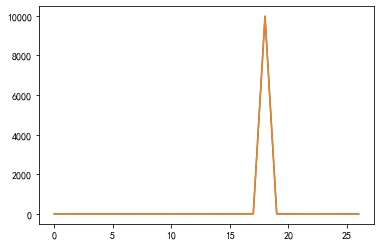

In [40]:
score_array,groupy,_ = mpd.score(sta_all,mem.mae,s={"hour":20,"id":54398,"dtime":39},g = "time")
plt.plot(score_array)

上述结果显示有1个时刻的检验指标存在两个异常值导致总体检验结果明显偏高。以下进一步锁定异常的日期

In [41]:
index = np.where(score_array[:,0] > 100)[0]
print(sta.iloc[index,:])

      level                time  dtime     id    lon   lat   ob  ecmwf  grapes
2730      0 2019-03-08 08:00:00     24  54398  116.6  40.1  6.2  3.556   2.348


通过上述诊断发现，观测值9999是造成检验指标异常的原因，由于9999并不是本系统默认的缺省值（nmb.IV = 999999）,因此在删除缺省值时未未对其进行过滤，为此可以采用如下方式进一步过滤：

In [42]:
sta_all_new = meb.sele_by_para(sta_all,value = [-100,100])
#重新从总样本中截取54398站点起报时间为每日20时的样本,计算每个预报时效的平均绝对误差的情况。
result = mpd.score(sta_all_new,mem.mae,s = {"hour":20,"id":54398},g= "dtime") 
print(result)

(array([[2.19057123, 6.61257124],
       [2.03462076, 5.69475872],
       [1.83406882, 4.95710338],
       [1.74548149, 4.12355556],
       [1.22868965, 2.43710349],
       [1.29627595, 2.44800018],
       [1.35034476, 2.41379297],
       [2.47848278, 3.92317245],
       [2.26096569, 4.79834492],
       [2.25682754, 4.4231724 ],
       [2.05641374, 4.03379309],
       [2.19724145, 3.92648283],
       [1.55944827, 2.52937925],
       [1.40938466, 2.38538459],
       [1.43671421, 2.51271428],
       [2.38414284, 4.13400001],
       [2.20786194, 4.9439999 ],
       [2.27944835, 4.41627586],
       [2.70700003, 4.78628566],
       [1.8092413 , 3.86165508],
       [1.38666674, 2.1293333 ],
       [1.37820689, 2.36703462],
       [1.14969241, 2.43846148],
       [1.78784613, 3.70661537],
       [2.07942863, 4.18414284]]), [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72], None)


In [43]:
result = mpd.score(sta_all_new,mem.cr,para1 = [0,10]) # ecmwf和grapes被视作一个集合预报的两个成员
print(result)    #shape = (len(para1))

(array([0.91205752, 0.83444907]), None, None)


从上面的示例中可以看出，基于本程序库提供的函数，实现了数据收集、数据提取和检验计算代码的解耦，使得我们检验分析的过程变得十分灵活，同时解耦也为各部分的进一步模块化提供了基础。值得注意的是采用上述方法进行检验时，会出现如下几个方面的问题：  
    1，将数据全部收集到sta_all变量当中,需要内存足够大  
    2，当sta_all太大时，从中做数据选取，速度会变慢   
    3，不能计算和存储检验中间检验量，也因此不能开展并行计算  
    4，目前只能支持按一个纬度进行简单的分组，不能按多个维度同时分组，例如将样本同时按月份和时效进行分组的功能无法提供。 
上述问题可以在更上一层（perspact）中提供解决方案  